# General Test

In [29]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd

def simulate(popularity, score, rate_hate_watching=0.3, real_count=0, verbose=0, return_line=False):
    t_end = 28
    t = np.arange(0, t_end, 1)

    # Parameters
    parameters = {
        "Prob Seeing Review": 0.2,

        "Initial Number Reviews": popularity*100,
        "Initial Score": score,
        "Score Max": 5,

        "Prob Hate Watching": rate_hate_watching,

        "Review Rate": 0.00005503175002855629,

        "Prob Indifference": 0.70,

        "Popularity": popularity,

        "Initial Population": 700_000_000,

        "Prob PP to NP": 0.36,
        "Prob PP to HW": 0.9,
        "Prob NP to PP": 0.5,
        "Prob NP to HW": 0.9,
        "Prob HW to PP": 0.25,
        "Prob HW to NP": 0.25,
        "Prob HW to HW": 0.9
    }

    # Initial Condition
    NW0 = round(min((parameters['Popularity'] / 100), 1) * parameters['Initial Population'], 0)

    PR0 = 0         # Amount of People who have seen mostly positive reviews about the movie
    NR0 = 0         # Amount of People who have seen mostly negative reviews about the movie

    PN0 = (parameters["Initial Score"]/parameters["Score Max"]) * parameters["Initial Number Reviews"]       # Amount of Initial Positive Reviews
    NN0 = parameters["Initial Number Reviews"] - PN0                                     # Amount of Initial Negative Reviews

    prob_liking = (parameters["Initial Score"]/parameters["Score Max"])

    PP0 = 0         # Amount of People who have seriously positive reception
    NP0 = 0         # Amount of People who have seriously negative reception
    HW0 = 0         # Amount of People who have hate-watched

    I0 = 0          # Amount of People who have become indifferent

    VC = 0          #view count

    # ODE System
    def model(t, y):
        NW, PR, NR, PP, NP, HW, I, PN, NN, VC = y
        dNWdt = -NW*parameters['Prob Seeing Review'] - parameters['Prob Indifference']*NW

        dPRdt = (PN/(PN+NN))*parameters['Prob Seeing Review']*NW - PR - parameters['Prob Indifference']*PR
        dNRdt = (NN/(PN+NN))*parameters['Prob Seeing Review']*NW - NR - parameters['Prob Indifference']*NR
        
    #     dPPdt = prob_liking*(PR+NR) - parameters['Prob Indifference']*PP 
    #     dNPdt = (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*NP
    #     dHWdt = (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*HW
        
        
        if PP + NP + HW == 0:
            dPPdt = prob_liking*(PR+NR) - parameters['Prob Indifference']*PP 
            dNPdt = (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*NP
            dHWdt = (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*HW
            
        else:
            dPPdt = prob_liking*(PR+NR) - parameters['Prob Indifference']*PP - (NP/(PP+NP+HW))*(1-prob_liking)*PP*parameters['Prob PP to NP'] - (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*PP*parameters['Prob PP to HW'] + (PP/(PP+NP+HW))*(prob_liking)*(parameters['Prob NP to PP']*NP+parameters['Prob HW to PP']*HW)
            dNPdt = (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*NP - (PP/(PP+NP+HW))*(prob_liking)*NP*parameters['Prob NP to PP'] - (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*NP*parameters['Prob NP to HW'] + (NP/(PP+NP+HW))*(1-prob_liking)*(parameters['Prob PP to NP']*PP+parameters['Prob HW to NP']*HW)
            dHWdt = (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*HW - (NP/(PP+NP+HW))*(1-prob_liking)*HW*parameters['Prob HW to NP'] - (PP/(PP+NP+HW))*(prob_liking)*HW*parameters['Prob HW to PP'] + (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*(parameters['Prob PP to HW']*PP+parameters['Prob NP to HW']*NP)

        dIdt = parameters['Prob Indifference']*(NW+PR+NR+PP+NP+HW)

        # Change in Review Count
        dPNdt = parameters["Review Rate"] * PP
        dNNdt = parameters["Review Rate"] * (NP+HW)
        
        if PP + NP + HW == 0:
            dVCdt = prob_liking*(PR+NR) + (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR) + (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR)
        
        else:
            dVCdt = prob_liking*(PR+NR)\
                 + (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR)\
                 + (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR)\
                 + (PP/(PP+NP+HW))*(prob_liking)*(parameters['Prob NP to PP']*NP+parameters['Prob HW to PP']*HW)\
                 + (NP/(PP+NP+HW))*(1-prob_liking)*(parameters['Prob PP to NP']*PP+parameters['Prob HW to NP']*HW)\
                 + (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*(parameters['Prob PP to HW']*PP+parameters['Prob NP to HW']*NP)\
                 + (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*(parameters['Prob HW to HW']*HW)
            
            # Compartmentalized
            dVCPdt = prob_liking*(PR+NR)\
                 + (PP/(PP+NP+HW))*(prob_liking)*(parameters['Prob NP to PP']*NP+parameters['Prob HW to PP']*HW)
            dVCNdt = (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR)\
                 + (NP/(PP+NP+HW))*(1-prob_liking)*(parameters['Prob PP to NP']*PP+parameters['Prob HW to NP']*HW)
            dVCHdt = (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR)\
                 + (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*(parameters['Prob PP to HW']*PP+parameters['Prob NP to HW']*NP)\
                 + (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*(parameters['Prob HW to HW']*HW) 

        return [dNWdt, dPRdt, dNRdt, dPPdt, dNPdt, dHWdt, dIdt, dPNdt, dNNdt, dVCdt]


    sol = solve_ivp(model, [t[0], t[-1]], [NW0, PR0, NR0, PP0, NP0, HW0, I0, PN0, NN0, VC], t_eval=t)

    if verbose > 0:
        plt.figure(figsize=(10, 5))
        # plt.plot(t, sol.y[0], label="Not Watched")

        plt.plot(t, sol.y[1], label="Positive Seen")
        plt.plot(t, sol.y[2], label="Negative Seen")

        plt.plot(t, sol.y[3], label="Positive Reception")
        plt.plot(t, sol.y[4], label="Negative Reception")
        plt.plot(t, sol.y[5], label="Hate Watched")

        # plt.plot(t, sol.y[6], label="Indifferent", color="#6407fa")
        # plt.plot(t, sol.y[9], label="View Count")

        # plt.plot(t, sol.y[7] + sol.y[8], label="Number Reviews", color="#07fa54")

        plt.xlabel("Time (in days)")
        plt.ylabel("Population")
        text = str(parameters["Initial Score"])+"/"+str(parameters["Score Max"])
        plt.title(f"Number of Population within a specific bucket in the Hate-Watching Model, Score: {text}")
        plt.legend(bbox_to_anchor=(1, 0.5))
        plt.show()

        print("Peak Positive Seen: ", round(sol.y[1].max(), 0))
        print("Peak Day: ", t[sol.y[1].argmax()])

        print("Peak Negative Seen: ", round(sol.y[2].max(), 0))
        print("Peak Day: ", t[sol.y[2].argmax()])

        print()

        print("Peak Positive Reception: ", round(sol.y[3].max(), 0))
        print("Peak Day: ", t[sol.y[3].argmax()])

        print("Peak Negative Reception: ", round(sol.y[4].max(), 0))
        print("Peak Day: ", t[sol.y[4].argmax()])

        print("Peak HateWatched Reception: ", round(sol.y[5].max(), 0))
        print("Peak Day: ", t[sol.y[5].argmax()])

        print()

        final_vc = round(sol.y[-1].max(), 0)
        print("View Count: ", round(sol.y[-1].max(), 0), ' / ', NW0)

    if return_line:
        return sol.y
    
    return real_count-round(sol.y[-1].max(), 0)

In [30]:
final_dataset = pd.read_csv('Final_Dataset_for_study.csv')
final_dataset['difference'] = final_dataset.apply(lambda x: abs(simulate(x['popularity'], x['rating'], real_count=x['approxviews'])), axis=1)
print("MEAN ABS DIFF: ", final_dataset['difference'].mean())
final_dataset['sqr_diff'] = final_dataset['difference'] * final_dataset['difference']
print("MEAN SQ ERROR: ", (final_dataset['sqr_diff'].mean())**(1/2))
final_dataset

MEAN ABS DIFF:  15400782.424390243
MEAN SQ ERROR:  29481020.450954154


,budget,id,revenue,popularity,release_date,vote_count,release_year,profit,approxviews,review_rate,movieId,rating,difference,sqr_diff
0,30000000.0,862,373554033.0,21.946943,1995-10-30,5415.0,1995,343554033.0,85874490,0.000063,862.0,3.598930,63138325.0,3.986448e+15
1,65000000.0,8844,262797249.0,17.015539,1995-12-15,2413.0,1995,197797249.0,60413160,0.000040,8844.0,3.760163,42989363.0,1.848085e+15
2,60000000.0,949,187436818.0,17.924927,1995-12-15,1886.0,1995,127436818.0,43088923,0.000044,949.0,3.905544,24937833.0,6.218955e+14
3,58000000.0,710,352194034.0,14.686036,1995-11-16,1194.0,1995,294194034.0,80964145,0.000015,710.0,2.740334,65034413.0,4.229475e+15
4,98000000.0,1408,10017322.0,7.284477,1995-12-22,137.0,1995,-87982678.0,2302832,0.000059,1408.0,3.710181,5184007.0,2.687393e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,5300000.0,8453,22175908.0,3.003526,2006-05-26,53.0,2006,16875908.0,3385634,0.000016,8453.0,3.037500,168672.0,2.845024e+10
1226,0.0,123229,103504.0,9.754955,2012-07-11,92.0,2012,103504.0,13003,0.007075,123229.0,2.150000,10721834.0,1.149577e+14
1227,2000000.0,159447,11666088.0,1.456046,2012-12-27,9.0,2012,9666088.0,1465588,0.000006,159447.0,3.326531,69645.0,4.850426e+09
1228,2000000.0,75438,8000000.0,0.397106,2011-07-21,7.0,2011,6000000.0,1008827,0.000007,75438.0,2.740506,578095.0,3.341938e+11


# Different Scores for Views

In [31]:
lines = {}
for score in range(1, 6):
    lines[score] = simulate(100, score, return_line=True)

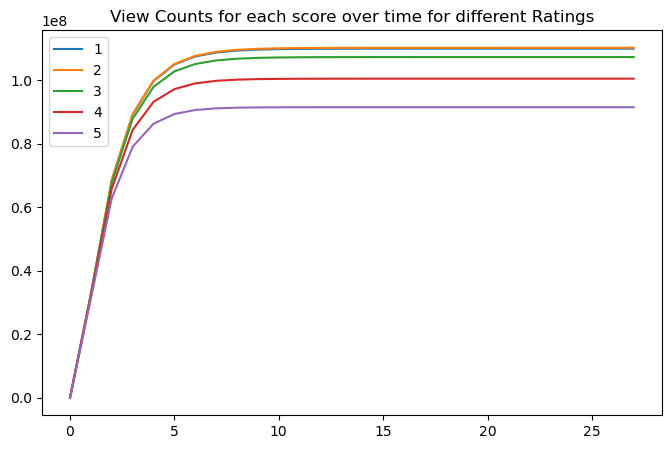

In [33]:
plt.figure(figsize=(8,5))
for score, line in lines.items():
    plt.plot(np.arange(0, 28, 1), line[9], label=score)
plt.legend()
plt.title("View Counts for each score over time for different Ratings")
plt.show()

# Different Rates of Hatewatching

In [ ]:
lines = {}
for i, rate in enumerate(np.arange(0, 1, 0.1)):
    lines[i] = simulate(100, 1, rate_hate_watching=rate, return_line=True)
lines

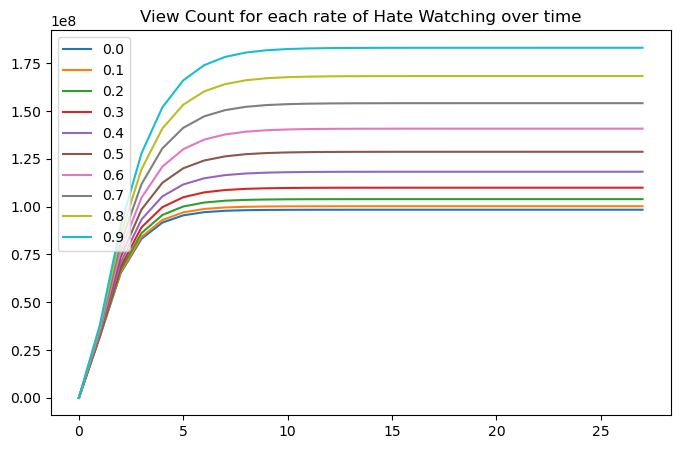

In [43]:
plt.figure(figsize=(8,5))
for score, line in lines.items():
    plt.plot(np.arange(0, 28, 1), line[9], label=score/10)
plt.legend()
plt.title("View Count for each rate of Hate Watching over time")
plt.show()

# Hate Watch vs Other Buckets for each rate

In [ ]:
for rate in np.arange(0, 1, 0.1):
    lines = {}
    for score in range(1, 6):
        lines[score] = simulate(100, score, rate_hate_watching=rate, return_line=True)
    plt.figure(figsize=(8,5))
    for score, line in lines.items():
        plt.plot(np.arange(0, 28, 1), line[9], label=score)
    plt.legend()
    plt.title("View Count for each rate of Hate Watching over time")
    plt.show()

In [ ]:
lines = {}
for i, rate in enumerate(np.arange(0, 1, 0.1)):
    lines[i] = simulate(100, 1, rate_hate_watching=rate, return_line=True)
lines

In [ ]:
plt.figure(figsize=(8,5))
for score, line in lines.items():
    plt.plot(np.arange(0, 28, 1), line[9], label=score/10)
plt.legend()
plt.title("View Count for each rate of Hate Watching over time")
plt.show()

# Test 1: Lord of the Rings 

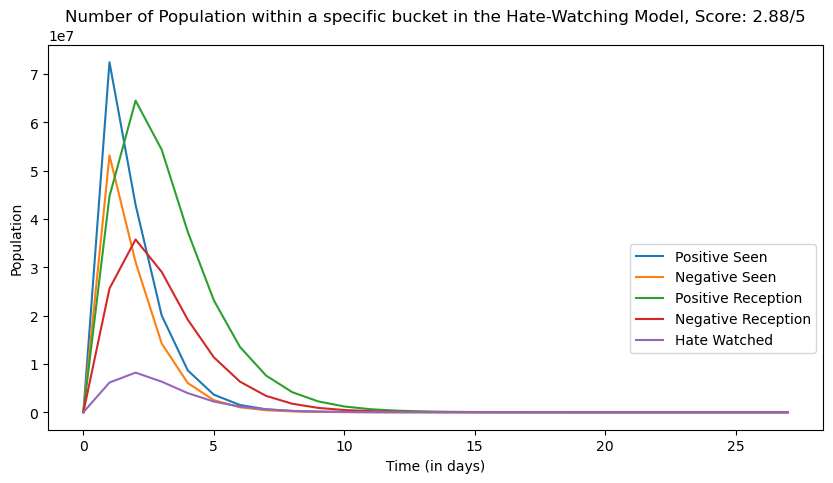

Peak Positive Seen:  72463632.0
Peak Day:  1
Peak Negative Seen:  53180717.0
Peak Day:  1

Peak Positive Reception:  64515426.0
Peak Day:  2
Peak Negative Reception:  35765089.0
Peak Day:  2
Peak HateWatched Reception:  8201046.0
Peak Day:  2

View Count:  344455010.0  /  2244950750.0
Diff View Count to Real View Count:  -190503003.0


In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

t_end = 28
t = np.arange(0, t_end, 1)

# Parameters
parameters = {
    "Prob Seeing Review": 0.2,

    "Initial Number Reviews": 3207,
    "Initial Score": 2.88,
    "Score Max": 5,

    "Prob Hate Watching": 0.2,

    "Review Rate": 0.00005503175002855629,

    "Prob Indifference": 0.70,

    "Popularity": 32.070725,

    "Initial Population": 7000000000,

    "Prob PP to NP": 0.5,
    "Prob PP to HW": 0.5,
    "Prob NP to PP": 0.5,
    "Prob NP to HW": 0.5,
    "Prob HW to PP": 0.5,
    "Prob HW to NP": 0.5,
    "Prob HW to HW": 0.5
}

# Initial Condition
NW0 = round(min((parameters['Popularity'] / 100), 1) * parameters['Initial Population'], 0)

PR0 = 0         # Amount of People who have seen mostly positive reviews about the movie
NR0 = 0         # Amount of People who have seen mostly negative reviews about the movie

PN0 = (parameters["Initial Score"]/parameters["Score Max"]) * parameters["Initial Number Reviews"]       # Amount of Initial Positive Reviews
NN0 = parameters["Initial Number Reviews"] - PN0                                     # Amount of Initial Negative Reviews

prob_liking = (parameters["Initial Score"]/parameters["Score Max"])

PP0 = 0         # Amount of People who have seriously positive reception
NP0 = 0         # Amount of People who have seriously negative reception
HW0 = 0         # Amount of People who have hate-watched

I0 = 0          # Amount of People who have become indifferent

VC = 0          #view count

# ODE System
def model(t, y):
    NW, PR, NR, PP, NP, HW, I, PN, NN, VC = y
    dNWdt = -NW*parameters['Prob Seeing Review'] - parameters['Prob Indifference']*NW

    dPRdt = (PN/(PN+NN))*parameters['Prob Seeing Review']*NW - PR - parameters['Prob Indifference']*PR
    dNRdt = (NN/(PN+NN))*parameters['Prob Seeing Review']*NW - NR - parameters['Prob Indifference']*NR
    
#     dPPdt = prob_liking*(PR+NR) - parameters['Prob Indifference']*PP 
#     dNPdt = (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*NP
#     dHWdt = (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*HW
    
    
    if PP + NP + HW == 0:
        dPPdt = prob_liking*(PR+NR) - parameters['Prob Indifference']*PP 
        dNPdt = (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*NP
        dHWdt = (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*HW
        
    else:
        dPPdt = prob_liking*(PR+NR) - parameters['Prob Indifference']*PP - (NP/(PP+NP+HW))*(1-prob_liking)*PP*parameters['Prob PP to NP'] - (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*PP*parameters['Prob PP to HW'] + (PP/(PP+NP+HW))*(prob_liking)*(parameters['Prob NP to PP']*NP+parameters['Prob HW to PP']*HW)
        dNPdt = (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*NP - (PP/(PP+NP+HW))*(prob_liking)*NP*parameters['Prob NP to PP'] - (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*NP*parameters['Prob NP to HW'] + (NP/(PP+NP+HW))*(1-prob_liking)*(parameters['Prob PP to NP']*PP+parameters['Prob HW to NP']*HW)
        dHWdt = (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*HW - (NP/(PP+NP+HW))*(1-prob_liking)*HW*parameters['Prob HW to NP'] - (PP/(PP+NP+HW))*(prob_liking)*HW*parameters['Prob HW to PP'] + (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*(parameters['Prob PP to HW']*PP+parameters['Prob NP to HW']*NP)

    dIdt = parameters['Prob Indifference']*(NW+PR+NR+PP+NP+HW)

    # Change in Review Count
    dPNdt = parameters["Review Rate"] * PP
    dNNdt = parameters["Review Rate"] * (NP+HW)
    
    if PP + NP + HW == 0:
        dVCdt = prob_liking*(PR+NR) + (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR) + (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR)
    
    else:
        dVCdt = prob_liking*(PR+NR) + (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR) + (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR) + (PP/(PP+NP+HW))*(prob_liking)*(parameters['Prob NP to PP']*NP+parameters['Prob HW to PP']*HW) + (NP/(PP+NP+HW))*(1-prob_liking)*(parameters['Prob PP to NP']*PP+parameters['Prob HW to NP']*HW) + (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*(parameters['Prob PP to HW']*PP+parameters['Prob NP to HW']*NP) + (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*(parameters['Prob HW to HW']*HW)

    return [dNWdt, dPRdt, dNRdt, dPPdt, dNPdt, dHWdt, dIdt, dPNdt, dNNdt, dVCdt]


sol = solve_ivp(model, [t[0], t[-1]], [NW0, PR0, NR0, PP0, NP0, HW0, I0, PN0, NN0, VC], t_eval=t)

plt.figure(figsize=(10, 5))
# plt.plot(t, sol.y[0], label="Not Watched")

plt.plot(t, sol.y[1], label="Positive Seen")
plt.plot(t, sol.y[2], label="Negative Seen")

plt.plot(t, sol.y[3], label="Positive Reception")
plt.plot(t, sol.y[4], label="Negative Reception")
plt.plot(t, sol.y[5], label="Hate Watched")

# plt.plot(t, sol.y[6], label="Indifferent", color="#6407fa")
# plt.plot(t, sol.y[9], label="View Count")

# plt.plot(t, sol.y[7] + sol.y[8], label="Number Reviews", color="#07fa54")

plt.xlabel("Time (in days)")
plt.ylabel("Population")
text = str(parameters["Initial Score"])+"/"+str(parameters["Score Max"])
plt.title(f"Number of Population within a specific bucket in the Hate-Watching Model, Score: {text}")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()

print("Peak Positive Seen: ", round(sol.y[1].max(), 0))
print("Peak Day: ", t[sol.y[1].argmax()])

print("Peak Negative Seen: ", round(sol.y[2].max(), 0))
print("Peak Day: ", t[sol.y[2].argmax()])

print()

print("Peak Positive Reception: ", round(sol.y[3].max(), 0))
print("Peak Day: ", t[sol.y[3].argmax()])

print("Peak Negative Reception: ", round(sol.y[4].max(), 0))
print("Peak Day: ", t[sol.y[4].argmax()])

print("Peak HateWatched Reception: ", round(sol.y[5].max(), 0))
print("Peak Day: ", t[sol.y[5].argmax()])

print()

final_vc = round(sol.y[-1].max(), 0)

print("View Count: ", round(sol.y[-1].max(), 0), ' / ', NW0)
print("Diff View Count to Real View Count: ", 153952007-final_vc)

# Test 2: Inside Out

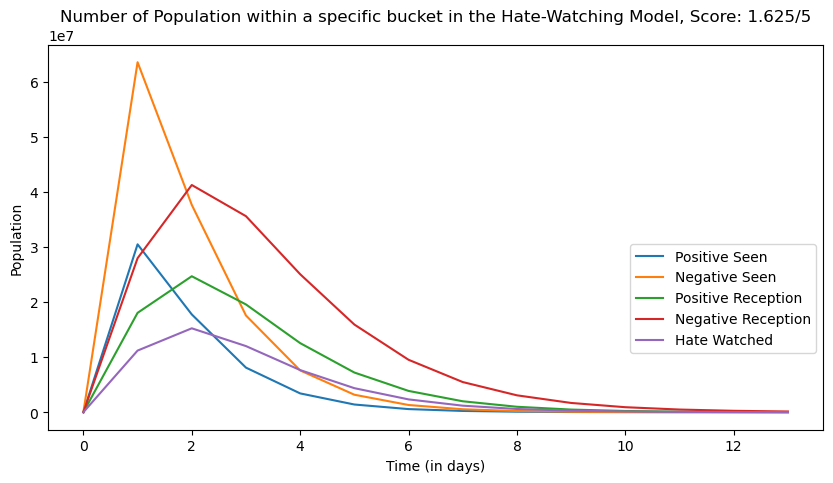

Peak Positive Seen:  30465262.0
Peak Day:  1
Peak Negative Seen:  63506772.0
Peak Day:  1

Peak Positive Reception:  24672549.0
Peak Day:  2
Peak Negative Reception:  41227601.0
Peak Day:  2
Peak HateWatched Reception:  15225242.0
Peak Day:  2

View Count:  264251691.0  /  1678991090.0
Diff View Count to Real View Count:  -162518456.0


In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

t_end = 14
t = np.arange(0, t_end, 1)

# Parameters
parameters = {
    "Prob Seeing Review": 0.2,

    "Initial Number Reviews": 2399,
    "Initial Score": 1.625,
    "Score Max": 5,

    "Prob Hate Watching": 0.3,

    "Review Rate": 0.00005503175002855629,

    "Prob Indifference": 0.70,

    "Popularity": 23.985587,

    "Initial Population": 7000000000,

    "Prob PP to NP": 0.5,
    "Prob PP to HW": 0.5,
    "Prob NP to PP": 0.5,
    "Prob NP to HW": 0.5,
    "Prob HW to PP": 0.5,
    "Prob HW to NP": 0.5,
    "Prob HW to HW": 0.5
}

# Initial Condition
NW0 = round(min((parameters['Popularity'] / 100), 1) * parameters['Initial Population'], 0)

PR0 = 0         # Amount of People who have seen mostly positive reviews about the movie
NR0 = 0         # Amount of People who have seen mostly negative reviews about the movie

PN0 = (parameters["Initial Score"]/parameters["Score Max"]) * parameters["Initial Number Reviews"]       # Amount of Initial Positive Reviews
NN0 = parameters["Initial Number Reviews"] - PN0                                     # Amount of Initial Negative Reviews

prob_liking = (parameters["Initial Score"]/parameters["Score Max"])

PP0 = 0         # Amount of People who have seriously positive reception
NP0 = 0         # Amount of People who have seriously negative reception
HW0 = 0         # Amount of People who have hate-watched

I0 = 0          # Amount of People who have become indifferent

VC = 0          #view count

# ODE System
def model(t, y):
    NW, PR, NR, PP, NP, HW, I, PN, NN, VC = y
    dNWdt = -NW*parameters['Prob Seeing Review'] - parameters['Prob Indifference']*NW

    dPRdt = (PN/(PN+NN))*parameters['Prob Seeing Review']*NW - PR - parameters['Prob Indifference']*PR
    dNRdt = (NN/(PN+NN))*parameters['Prob Seeing Review']*NW - NR - parameters['Prob Indifference']*NR
    
#     dPPdt = prob_liking*(PR+NR) - parameters['Prob Indifference']*PP 
#     dNPdt = (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*NP
#     dHWdt = (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*HW
    
    
    if PP + NP + HW == 0:
        dPPdt = prob_liking*(PR+NR) - parameters['Prob Indifference']*PP 
        dNPdt = (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*NP
        dHWdt = (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*HW
        
    else:
        dPPdt = prob_liking*(PR+NR) - parameters['Prob Indifference']*PP - (NP/(PP+NP+HW))*(1-prob_liking)*PP*parameters['Prob PP to NP'] - (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*PP*parameters['Prob PP to HW'] + (PP/(PP+NP+HW))*(prob_liking)*(parameters['Prob NP to PP']*NP+parameters['Prob HW to PP']*HW)
        dNPdt = (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*NP - (PP/(PP+NP+HW))*(prob_liking)*NP*parameters['Prob NP to PP'] - (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*NP*parameters['Prob NP to HW'] + (NP/(PP+NP+HW))*(1-prob_liking)*(parameters['Prob PP to NP']*PP+parameters['Prob HW to NP']*HW)
        dHWdt = (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*HW - (NP/(PP+NP+HW))*(1-prob_liking)*HW*parameters['Prob HW to NP'] - (PP/(PP+NP+HW))*(prob_liking)*HW*parameters['Prob HW to PP'] + (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*(parameters['Prob PP to HW']*PP+parameters['Prob NP to HW']*NP)

    dIdt = parameters['Prob Indifference']*(NW+PR+NR+PP+NP+HW)

    # Change in Review Count
    dPNdt = parameters["Review Rate"] * PP
    dNNdt = parameters["Review Rate"] * (NP+HW)
    
    if PP + NP + HW == 0:
        dVCdt = prob_liking*(PR+NR) + (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR) + (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR)
    
    else:
        dVCdt = prob_liking*(PR+NR) + (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR) + (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR) + (PP/(PP+NP+HW))*(prob_liking)*(parameters['Prob NP to PP']*NP+parameters['Prob HW to PP']*HW) + (NP/(PP+NP+HW))*(1-prob_liking)*(parameters['Prob PP to NP']*PP+parameters['Prob HW to NP']*HW) + (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*(parameters['Prob PP to HW']*PP+parameters['Prob NP to HW']*NP) + (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*(parameters['Prob HW to HW']*HW)

    return [dNWdt, dPRdt, dNRdt, dPPdt, dNPdt, dHWdt, dIdt, dPNdt, dNNdt, dVCdt]


sol = solve_ivp(model, [t[0], t[-1]], [NW0, PR0, NR0, PP0, NP0, HW0, I0, PN0, NN0, VC], t_eval=t)

plt.figure(figsize=(10, 5))
# plt.plot(t, sol.y[0], label="Not Watched")

plt.plot(t, sol.y[1], label="Positive Seen")
plt.plot(t, sol.y[2], label="Negative Seen")

plt.plot(t, sol.y[3], label="Positive Reception")
plt.plot(t, sol.y[4], label="Negative Reception")
plt.plot(t, sol.y[5], label="Hate Watched")

# plt.plot(t, sol.y[6], label="Indifferent", color="#6407fa")
# plt.plot(t, sol.y[9], label="View Count")

# plt.plot(t, sol.y[7] + sol.y[8], label="Number Reviews", color="#07fa54")

plt.xlabel("Time (in days)")
plt.ylabel("Population")
text = str(parameters["Initial Score"])+"/"+str(parameters["Score Max"])
plt.title(f"Number of Population within a specific bucket in the Hate-Watching Model, Score: {text}")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()

print("Peak Positive Seen: ", round(sol.y[1].max(), 0))
print("Peak Day: ", t[sol.y[1].argmax()])

print("Peak Negative Seen: ", round(sol.y[2].max(), 0))
print("Peak Day: ", t[sol.y[2].argmax()])

print()

print("Peak Positive Reception: ", round(sol.y[3].max(), 0))
print("Peak Day: ", t[sol.y[3].argmax()])

print("Peak Negative Reception: ", round(sol.y[4].max(), 0))
print("Peak Day: ", t[sol.y[4].argmax()])

print("Peak HateWatched Reception: ", round(sol.y[5].max(), 0))
print("Peak Day: ", t[sol.y[5].argmax()])

print()

final_vc = round(sol.y[-1].max(), 0)

print("View Count: ", round(sol.y[-1].max(), 0), ' / ', NW0)
print("Diff View Count to Real View Count: ", 101733235-final_vc)

# Test 3: Teenage Mutant Ninja Turtles

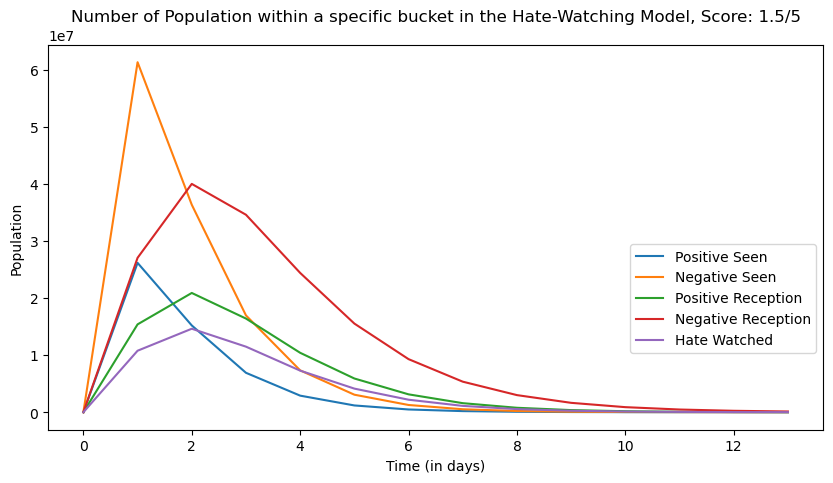

Peak Positive Seen:  26178458.0
Peak Day:  1
Peak Negative Seen:  61347431.0
Peak Day:  1

Peak Positive Reception:  20904693.0
Peak Day:  2
Peak Negative Reception:  40020271.0
Peak Day:  2
Peak HateWatched Reception:  14633285.0
Peak Day:  2

View Count:  245646579.0  /  1563800000.0
Diff View Count to Real View Count:  -187237767.0


In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

t_end = 14
t = np.arange(0, t_end, 1)

# Parameters
parameters = {
    "Prob Seeing Review": 0.2,

    "Initial Number Reviews": 2234,
    "Initial Score": 1.5,
    "Score Max": 5,

    "Prob Hate Watching": 0.3,

    "Review Rate": 0.00005503175002855629,

    "Prob Indifference": 0.70,

    "Popularity": 22.34,

    "Initial Population": 7000000000,

    "Prob PP to NP": 0.5,
    "Prob PP to HW": 0.5,
    "Prob NP to PP": 0.5,
    "Prob NP to HW": 0.5,
    "Prob HW to PP": 0.5,
    "Prob HW to NP": 0.5,
    "Prob HW to HW": 0.5
}

# Initial Condition
NW0 = round(min((parameters['Popularity'] / 100), 1) * parameters['Initial Population'], 0)

PR0 = 0         # Amount of People who have seen mostly positive reviews about the movie
NR0 = 0         # Amount of People who have seen mostly negative reviews about the movie

PN0 = (parameters["Initial Score"]/parameters["Score Max"]) * parameters["Initial Number Reviews"]       # Amount of Initial Positive Reviews
NN0 = parameters["Initial Number Reviews"] - PN0                                     # Amount of Initial Negative Reviews

prob_liking = (parameters["Initial Score"]/parameters["Score Max"])

PP0 = 0         # Amount of People who have seriously positive reception
NP0 = 0         # Amount of People who have seriously negative reception
HW0 = 0         # Amount of People who have hate-watched

I0 = 0          # Amount of People who have become indifferent

VC = 0          #view count

# ODE System
def model(t, y):
    NW, PR, NR, PP, NP, HW, I, PN, NN, VC = y
    dNWdt = -NW*parameters['Prob Seeing Review'] - parameters['Prob Indifference']*NW

    dPRdt = (PN/(PN+NN))*parameters['Prob Seeing Review']*NW - PR - parameters['Prob Indifference']*PR
    dNRdt = (NN/(PN+NN))*parameters['Prob Seeing Review']*NW - NR - parameters['Prob Indifference']*NR
    
#     dPPdt = prob_liking*(PR+NR) - parameters['Prob Indifference']*PP 
#     dNPdt = (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*NP
#     dHWdt = (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*HW
    
    
    if PP + NP + HW == 0:
        dPPdt = prob_liking*(PR+NR) - parameters['Prob Indifference']*PP 
        dNPdt = (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*NP
        dHWdt = (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*HW
        
    else:
        dPPdt = prob_liking*(PR+NR) - parameters['Prob Indifference']*PP - (NP/(PP+NP+HW))*(1-prob_liking)*PP*parameters['Prob PP to NP'] - (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*PP*parameters['Prob PP to HW'] + (PP/(PP+NP+HW))*(prob_liking)*(parameters['Prob NP to PP']*NP+parameters['Prob HW to PP']*HW)
        dNPdt = (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*NP - (PP/(PP+NP+HW))*(prob_liking)*NP*parameters['Prob NP to PP'] - (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*NP*parameters['Prob NP to HW'] + (NP/(PP+NP+HW))*(1-prob_liking)*(parameters['Prob PP to NP']*PP+parameters['Prob HW to NP']*HW)
        dHWdt = (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*HW - (NP/(PP+NP+HW))*(1-prob_liking)*HW*parameters['Prob HW to NP'] - (PP/(PP+NP+HW))*(prob_liking)*HW*parameters['Prob HW to PP'] + (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*(parameters['Prob PP to HW']*PP+parameters['Prob NP to HW']*NP)

    dIdt = parameters['Prob Indifference']*(NW+PR+NR+PP+NP+HW)

    # Change in Review Count
    dPNdt = parameters["Review Rate"] * PP
    dNNdt = parameters["Review Rate"] * (NP+HW)
    
    if PP + NP + HW == 0:
        dVCdt = prob_liking*(PR+NR) + (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR) + (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR)
    
    else:
        dVCdt = prob_liking*(PR+NR) + (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR) + (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR) + (PP/(PP+NP+HW))*(prob_liking)*(parameters['Prob NP to PP']*NP+parameters['Prob HW to PP']*HW) + (NP/(PP+NP+HW))*(1-prob_liking)*(parameters['Prob PP to NP']*PP+parameters['Prob HW to NP']*HW) + (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*(parameters['Prob PP to HW']*PP+parameters['Prob NP to HW']*NP) + (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*(parameters['Prob HW to HW']*HW)

    return [dNWdt, dPRdt, dNRdt, dPPdt, dNPdt, dHWdt, dIdt, dPNdt, dNNdt, dVCdt]


sol = solve_ivp(model, [t[0], t[-1]], [NW0, PR0, NR0, PP0, NP0, HW0, I0, PN0, NN0, VC], t_eval=t)

plt.figure(figsize=(10, 5))
# plt.plot(t, sol.y[0], label="Not Watched")

plt.plot(t, sol.y[1], label="Positive Seen")
plt.plot(t, sol.y[2], label="Negative Seen")

plt.plot(t, sol.y[3], label="Positive Reception")
plt.plot(t, sol.y[4], label="Negative Reception")
plt.plot(t, sol.y[5], label="Hate Watched")

# plt.plot(t, sol.y[6], label="Indifferent", color="#6407fa")
# plt.plot(t, sol.y[9], label="View Count")

# plt.plot(t, sol.y[7] + sol.y[8], label="Number Reviews", color="#07fa54")

plt.xlabel("Time (in days)")
plt.ylabel("Population")
text = str(parameters["Initial Score"])+"/"+str(parameters["Score Max"])
plt.title(f"Number of Population within a specific bucket in the Hate-Watching Model, Score: {text}")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()

print("Peak Positive Seen: ", round(sol.y[1].max(), 0))
print("Peak Day: ", t[sol.y[1].argmax()])

print("Peak Negative Seen: ", round(sol.y[2].max(), 0))
print("Peak Day: ", t[sol.y[2].argmax()])

print()

print("Peak Positive Reception: ", round(sol.y[3].max(), 0))
print("Peak Day: ", t[sol.y[3].argmax()])

print("Peak Negative Reception: ", round(sol.y[4].max(), 0))
print("Peak Day: ", t[sol.y[4].argmax()])

print("Peak HateWatched Reception: ", round(sol.y[5].max(), 0))
print("Peak Day: ", t[sol.y[5].argmax()])

print()

final_vc = round(sol.y[-1].max(), 0)

print("View Count: ", round(sol.y[-1].max(), 0), ' / ', NW0)
print("Diff View Count to Real View Count: ", 58408812-final_vc)